In [23]:
# Standard Libraries
import os # operating system dependent functionality
from collections import Counter # counting elements in an iterable

# External Libraries
import numpy as np # numerical operations on data arrays and matrices
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt # plotting and visualizations
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

# Bioinformatics and Data Analysis 
import anndata # handling annotated data, particularly in genomics
import scanpy as sc # single-cell RNA-seq data analysis
import scipy # scientific and technical computations

# Confusion Matrix visualization
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import seaborn as sns

In [2]:
import ot 

# Load human and mouse processed and homolog intersected data

In [3]:
# load processed AnnData objects for human and mouse cells
human_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_data/human_pancreas_preprocessed_log10_homolog_intersected_adata.h5ad")
mouse_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_data/mouse_pancreas_preprocessed_log10_homolog_intersected_adata.h5ad")

In [4]:
# Ensure organism key is present for both human and mouse
if 'organism' not in human_restricted.obs:
    human_restricted.obs['organism'] = 'Homo sapiens'
if 'organism' not in mouse_restricted.obs:
    mouse_restricted.obs['organism'] = 'Mus musculus'

# Ensure cell_tyope key is present - slightly misworded
if 'cell_type' not in human_restricted.obs:
    human_restricted.obs['cell_type'] = human_restricted.obs['cell_types']
if 'cell_type' not in mouse_restricted.obs:
    mouse_restricted.obs['cell_type'] = mouse_restricted.obs['cell_types']

human_restricted.obs['cell_type'] = [x.lower() for x in human_restricted.obs['cell_type']]
mouse_restricted.obs['cell_type'] = [x.lower() for x in mouse_restricted.obs['cell_type']]

# Add species labels
human_restricted.obs['species'] = 'human'
mouse_restricted.obs['species'] = 'mouse'

In [5]:
human_restricted

AnnData object with n_obs × n_vars = 8569 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'organism', 'cell_type', 'species'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ensembl_id'

# Finding Nearest Neighbors

### Method 2) Optimal Transport

In [6]:
def optimal_transport_pairing(adata_human, adata_mouse):
    """
    Compute the optimal transport (OT) pairing between human and mouse cells.

    Parameters:
    - adata_human: AnnData object for human cells.
    - adata_mouse: AnnData object for mouse cells.

    Returns:
    - paired_indices: List of tuples (human_index, mouse_index) of paired cells.
    """
    # Convert sparse matrix to dense if necessary
    if isinstance(adata_human.X, np.ndarray):
        X_human = adata_human.X
    else:
        X_human = adata_human.X.toarray()
    
    if isinstance(adata_mouse.X, np.ndarray):
        X_mouse = adata_mouse.X
    else:
        X_mouse = adata_mouse.X.toarray()

    # Compute the cost matrix using Euclidean distance
    cost_matrix = ot.dist(X_human, X_mouse, metric='euclidean')

    # Visualize the cost matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cost_matrix, aspect='auto', cmap='viridis')
    plt.colorbar(label='Euclidean Distance')
    plt.title('Cost Matrix (Euclidean Distance)')
    plt.xlabel('Mouse Cells')
    plt.ylabel('Human Cells')
    plt.show()

    # Uniform distribution over human and mouse cells
    human_distribution = np.ones(X_human.shape[0]) / X_human.shape[0]
    mouse_distribution = np.ones(X_mouse.shape[0]) / X_mouse.shape[0]

    # Compute the optimal transport matrix using the Earth Mover's Distance
    ot_matrix = ot.emd(human_distribution, mouse_distribution, cost_matrix)

    # Find the optimal pairs based on the transport plan
    paired_indices = []
    for human_idx in range(ot_matrix.shape[0]):
        mouse_idx = np.argmax(ot_matrix[human_idx])
        paired_indices.append((human_idx, mouse_idx))

    return paired_indices, ot_matrix

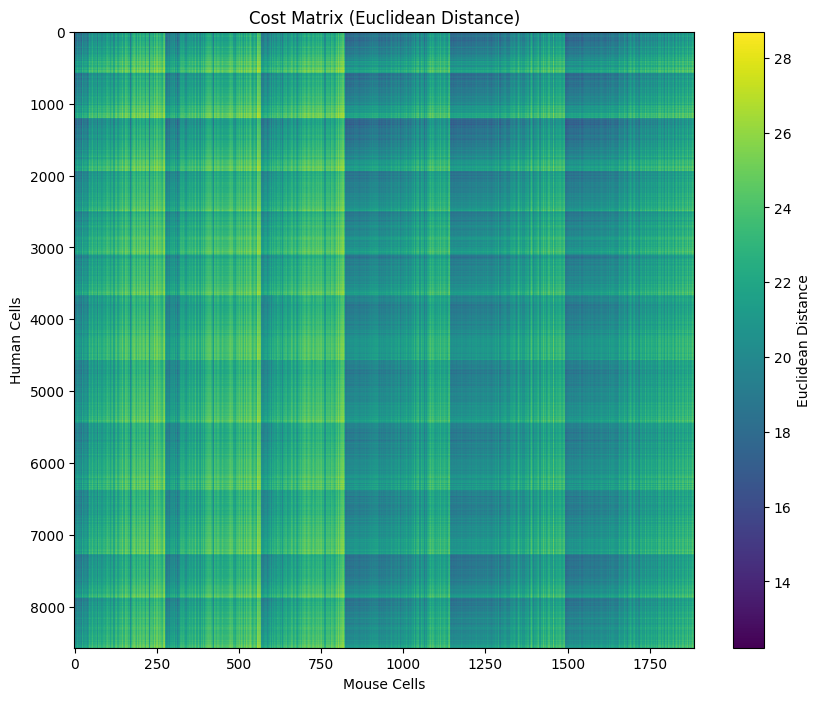

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


8569

In [7]:
paired_indices, ot_matrix = optimal_transport_pairing(human_restricted, mouse_restricted)
len(paired_indices)

In [8]:
print(paired_indices[0])
print(paired_indices[1])
print(paired_indices[2])

(0, 196)
(1, 27)
(2, 229)


In [9]:
print(paired_indices[:50])

[(0, 196), (1, 27), (2, 229), (3, 98), (4, 302), (5, 136), (6, 1508), (7, 771), (8, 592), (9, 257), (10, 1354), (11, 229), (12, 918), (13, 866), (14, 568), (15, 1390), (16, 1241), (17, 526), (18, 1), (19, 879), (20, 1160), (21, 1546), (22, 284), (23, 828), (24, 866), (25, 1200), (26, 1183), (27, 357), (28, 173), (29, 1180), (30, 121), (31, 362), (32, 340), (33, 42), (34, 1339), (35, 686), (36, 632), (37, 1509), (38, 1574), (39, 863), (40, 1393), (41, 1509), (42, 4), (43, 119), (44, 1221), (45, 24), (46, 321), (47, 24), (48, 23), (49, 945)]


In [10]:
# Combine the datasets to perform OT
combined_adata = anndata.concat([human_restricted, mouse_restricted], merge='same')

# Ensure UMAP is computed and stored in the AnnData object
if 'X_umap' not in combined_adata.obsm:
    sc.pp.neighbors(combined_adata)
    sc.tl.umap(combined_adata)


         Falling back to preprocessing with `sc.pp.pca` and default params.


In [11]:
# Create the "plots" directory if it doesn't exist
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


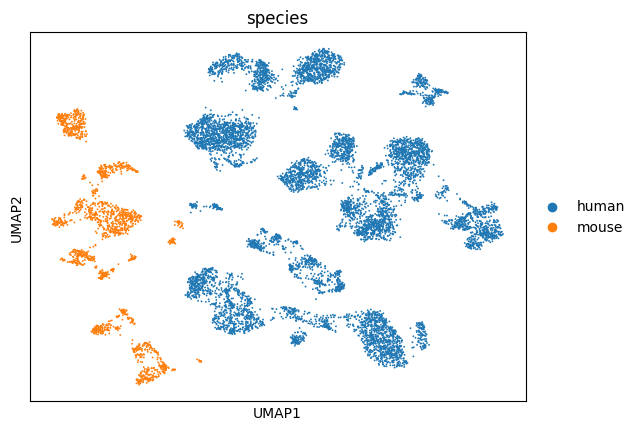

UMAP plot saved to plots/umap_homologous_data_colored_by_species.png


In [12]:
# Optional: Visualize the optimal transport pairs on UMAP
sc.pp.neighbors(combined_adata, use_rep='X_pca')
sc.tl.umap(combined_adata)

# Visualize UMAP
umap_species_plot_path = os.path.join(plots_dir, "umap_homologous_data_colored_by_species.png")
fig = sc.pl.umap(combined_adata, color=['species'], return_fig=True, s=7)
plt.show()

# Save the plot using matplotlib
fig.savefig(umap_species_plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_species_plot_path}")


/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


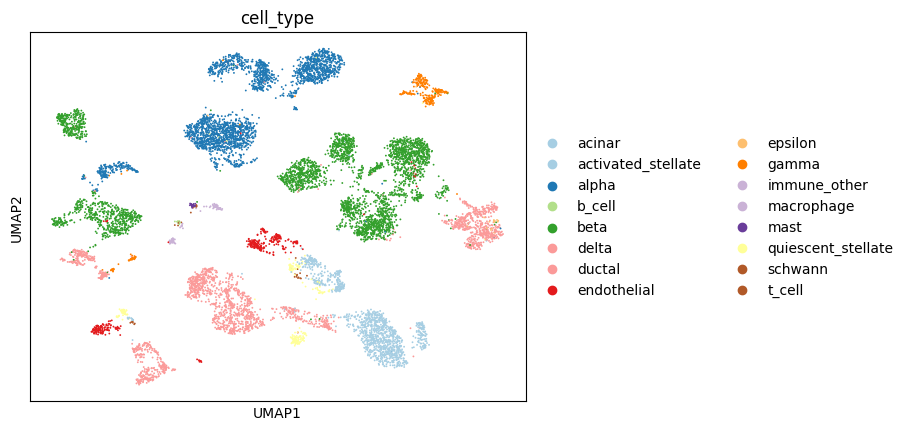

UMAP plot saved to plots/umap_homologous_data_colored_by_cell_type.png


In [13]:
# Optional: Visualize the optimal transport pairs on UMAP
sc.pp.neighbors(combined_adata, use_rep='X_pca')
sc.tl.umap(combined_adata)

# Visualize UMAP
umap_cell_type_plot_path = os.path.join(plots_dir, "umap_homologous_data_colored_by_cell_type.png")
fig = sc.pl.umap(combined_adata, color=['cell_type'], return_fig=True, palette="Paired", s=7)
plt.show()

# Save the plot using matplotlib
fig.savefig(umap_cell_type_plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_cell_type_plot_path}")

# Plot classic OT pairs on umap, showing cell_type and species plots

In [20]:
def plot_joint_umap_with_pairs(
    human_mouse_joint_adata,
    num_human_cells,
    paired_indices,
    color_label,
    save_path,
    title,
    cell_type=None,
    adata_human=None,
    adata_mouse=None,
    filter_by_human=True  # if True, shows which mouse cells all human cells map to, else vice versa
):
    """
    Create a joint UMAP of human and mouse AnnData objects and plot the lines connecting paired cells.

    Parameters:
    - human_mouse_adata: AnnData object for human and mouse cells.
    - paired_indices: List of tuples (human_index, mouse_index) of paired cells.
    - color_label: The column in `obs` to color by.
    - save_path: Path to save the plot.
    - cell_type: (Optional) Filter pairs by specific cell type.
    - adata_human: AnnData object for human cells.
    - adata_mouse: AnnData object for mouse cells.
    - filter_by_human: True to filter by human cell type, False to filter by mouse cell type.
    """
    # Ensure the "plots" directory exists
    plots_dir = os.path.join(os.getcwd(), "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    # Construct the full save path
    full_save_path = os.path.join(plots_dir, save_path)
    
    # Ensure UMAP is computed and stored in the AnnData object
    if 'X_umap' not in human_mouse_joint_adata.obsm:
        sc.pp.neighbors(human_mouse_joint_adata)
        sc.tl.umap(human_mouse_joint_adata)
    
    if color_label=='species':
        # Plot the UMAP
        sc.pl.umap(
            human_mouse_joint_adata, 
            color=color_label, 
            show=False, 
            s=7,
            title=title,
        )
    else:
        # Plot the UMAP
        sc.pl.umap(
            human_mouse_joint_adata, 
            color=color_label, 
            show=False, 
            palette="Paired",
            s=7,
            title=title,
        )

    # Extract the UMAP coordinates
    umap_human = human_mouse_joint_adata.obsm['X_umap'][:num_human_cells, :]
    umap_mouse = human_mouse_joint_adata.obsm['X_umap'][num_human_cells:, :]

    # Filter the paired indices based on the specified cell type, if provided
    if cell_type:
        if filter_by_human:
            human_cell_type_mask = adata_human.obs['cell_types'] == cell_type
            filtered_pairs = [
                (human_idx, mouse_idx) for human_idx, mouse_idx in paired_indices
                if human_cell_type_mask[human_idx]
            ]
        else:
            mouse_cell_type_mask = adata_mouse.obs['cell_types'] == cell_type
            filtered_pairs = [
                (human_idx, mouse_idx) for human_idx, mouse_idx in paired_indices
                if mouse_cell_type_mask[mouse_idx]
            ]
    else:
        # Use all pairs if no cell type is specified
        filtered_pairs = paired_indices

    # Plot lines connecting paired human and mouse cells
    for human_idx, mouse_idx in filtered_pairs:
        # Get the UMAP coordinates of the paired human and mouse cells
        human_coord = umap_human[human_idx]
        mouse_coord = umap_mouse[mouse_idx]
        
        # Plot a light gray line connecting the paired cells
        plt.plot([human_coord[0], mouse_coord[0]], 
                 [human_coord[1], mouse_coord[1]], 
                 color='lightgray', linewidth=0.6, alpha=0.2, linestyle="--")

    # Save the plot
    plt.savefig(full_save_path, facecolor="white", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()

    # Print confirmation
    print(f"Plot saved to {full_save_path}")

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


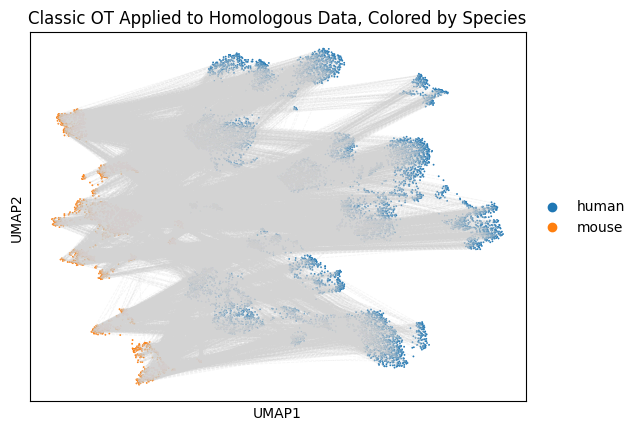

Plot saved to /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Classic OT on Homology Data(Replicating Syed's pancreas tissue experiment)/plots/classic_ot_paired_homologous_data_species.png


In [21]:
color_label='species'
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=combined_adata, 
    num_human_cells=human_restricted.shape[0],
    paired_indices=paired_indices, 
    color_label=color_label, 
    save_path="classic_ot_paired_homologous_data_species.png", 
    title=f"Classic OT Applied to Homologous Data, Colored by {str.capitalize(color_label)}",
    adata_human=human_restricted, 
    adata_mouse=mouse_restricted
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


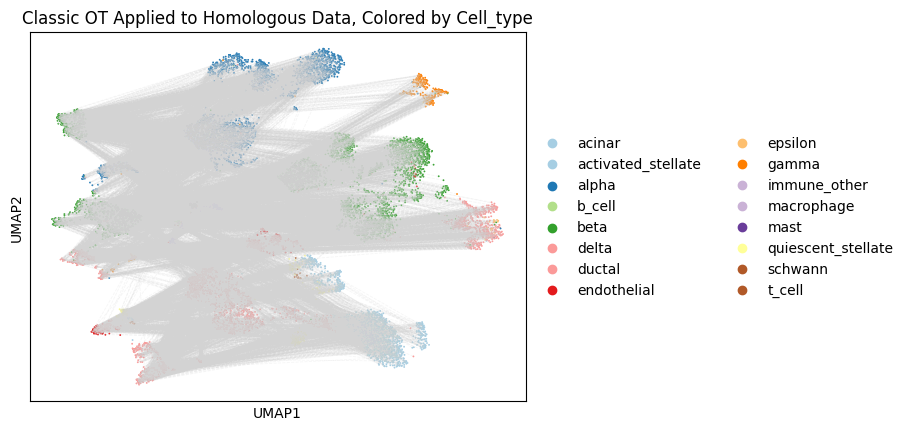

Plot saved to /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Classic OT on Homology Data(Replicating Syed's pancreas tissue experiment)/plots/classic_ot_paired_homologous_data_cell_type.png


In [22]:
color_label='cell_type'
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=combined_adata, 
    num_human_cells=human_restricted.shape[0],
    paired_indices=paired_indices, 
    color_label=color_label, 
    save_path="classic_ot_paired_homologous_data_cell_type.png", 
    title=f"Classic OT Applied to Homologous Data, Colored by {str.capitalize(color_label)}",
    adata_human=human_restricted, 
    adata_mouse=mouse_restricted
)

In [17]:
# Extract true labels
human_labels = [x.lower() for x in human_restricted.obs['cell_type'].values]
mouse_labels = [x.lower() for x in mouse_restricted.obs['cell_type'].values]

# Create lists of labels based on paired indices
paired_human_labels = [human_labels[p[0]] for p in paired_indices]
paired_mouse_labels = [mouse_labels[p[1]] for p in paired_indices]

# Ensure both label sets are consistent but separated by species
unique_human_labels = np.unique(human_labels)
unique_mouse_labels = np.unique(mouse_labels)
print("Unique human labels:", unique_human_labels)
print("Unique mouse labels:", unique_mouse_labels)

# Combine unique labels for human and mouse separately
all_labels = np.union1d(unique_human_labels, unique_mouse_labels)

Unique human labels: ['acinar' 'activated_stellate' 'alpha' 'beta' 'delta' 'ductal'
 'endothelial' 'epsilon' 'gamma' 'macrophage' 'mast' 'quiescent_stellate'
 'schwann' 't_cell']
Unique mouse labels: ['activated_stellate' 'alpha' 'b_cell' 'beta' 'delta' 'ductal'
 'endothelial' 'gamma' 'immune_other' 'macrophage' 'quiescent_stellate'
 'schwann' 't_cell']


In [18]:
same_cell_type = [x for x in all_labels if x in unique_human_labels and x in unique_mouse_labels]
print("Shared cell types in human and mice:", same_cell_type)

Shared cell types in human and mice: ['activated_stellate', 'alpha', 'beta', 'delta', 'ductal', 'endothelial', 'gamma', 'macrophage', 'quiescent_stellate', 'schwann', 't_cell']


In [24]:
plot_path = "classic_ot_homologous_data_confusion_matrix"
# Generate confusion matrix with consistent labels
cm = confusion_matrix(paired_human_labels, paired_mouse_labels, labels=all_labels)

# Convert to DataFrame for better visualization
cm_df = DataFrame(cm, index=all_labels, columns=all_labels)

# Compute row and column sums
row_sums = cm_df.sum(axis=1)
col_sums = cm_df.sum(axis=0)

# Filter rows and columns where the sum of values is not equal to 0
non_zero_rows = row_sums != 0
non_zero_cols = col_sums != 0

# Apply the filters to the DataFrame
filtered_cm_df = cm_df.loc[non_zero_rows, non_zero_cols]

# Define file path for the heatmap plot
cm_path = os.path.join(plots_dir, plot_path)

# Create a matplotlib figure and axis
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_cm_df, annot=True, fmt='d', cmap='Greens', linewidths=.4)
plt.title('Confusion Matrix of Human-Mouse Cell Pairs', fontsize=20)
plt.xlabel('Mouse Cell Types', fontsize=15)
plt.ylabel('Human Cell Types', fontsize=15)

# Save the plot using matplotlib
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"Confusion matrix plot saved to {cm_path}")


Confusion matrix plot saved to plots/classic_ot_homologous_data_confusion_matrix


/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


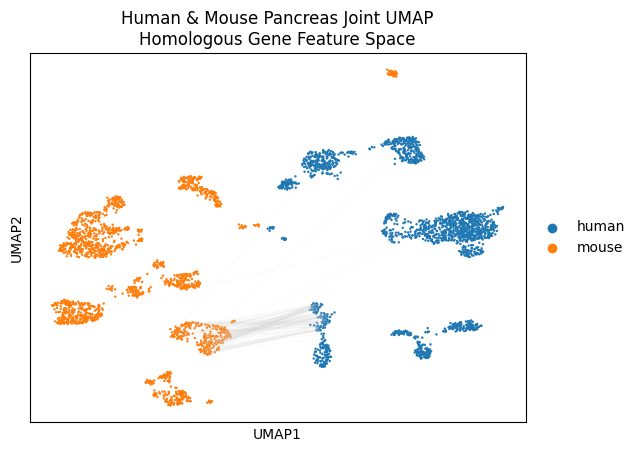

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


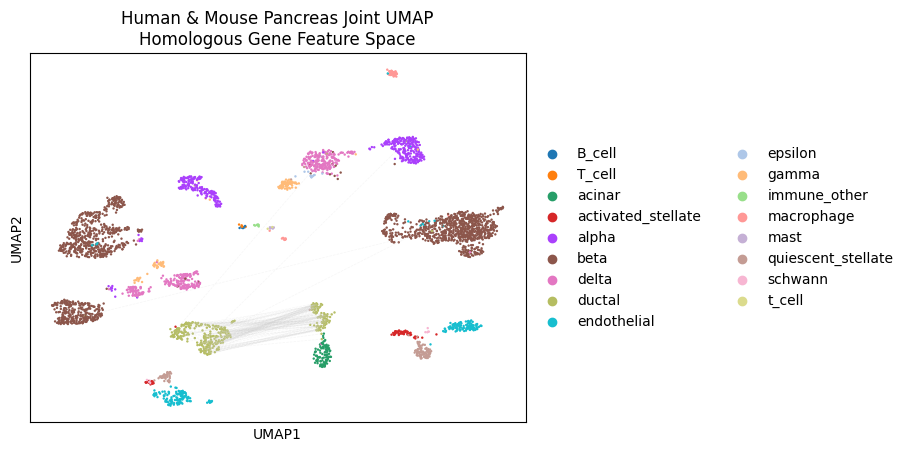

In [18]:
cell_type_label = "ductal"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


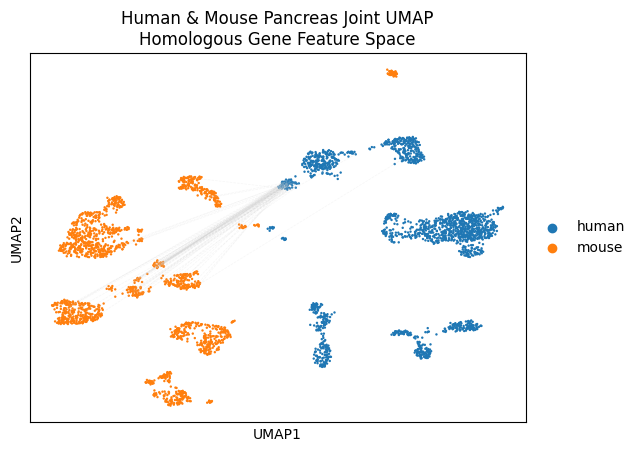

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


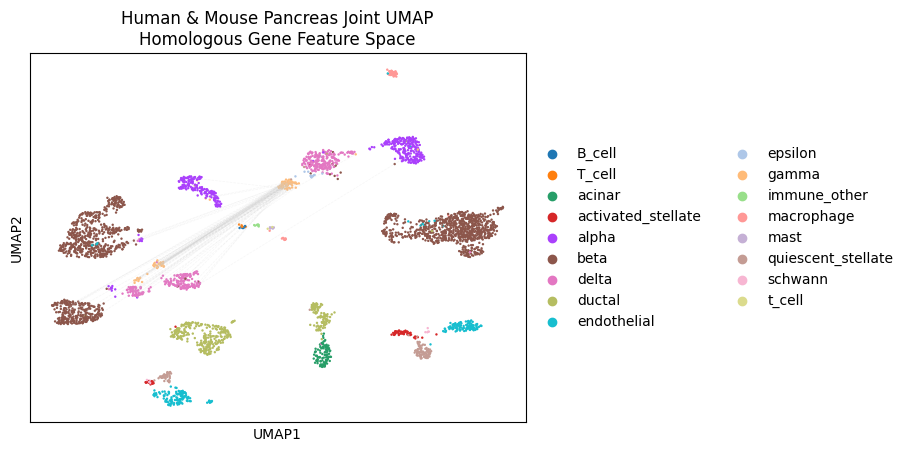

In [19]:
cell_type_label = "gamma"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


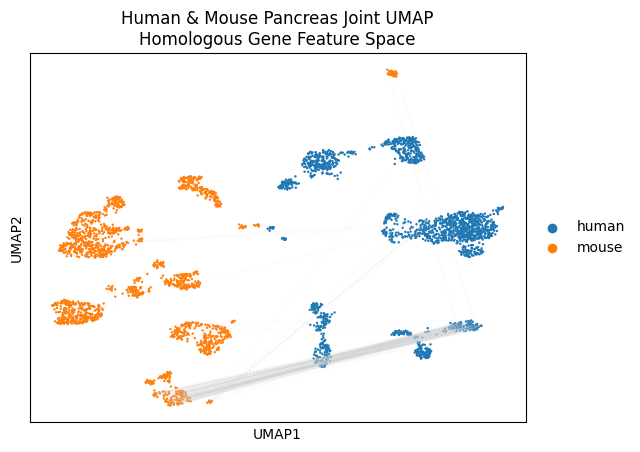

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


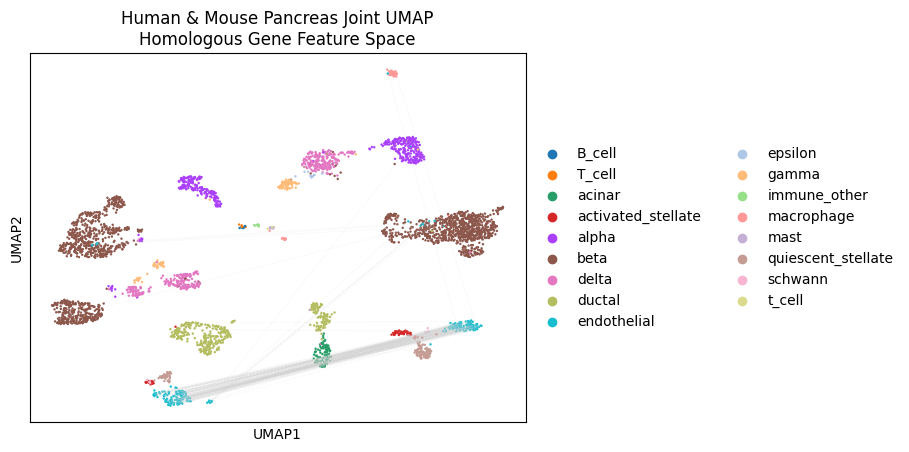

In [20]:
cell_type_label = "endothelial"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


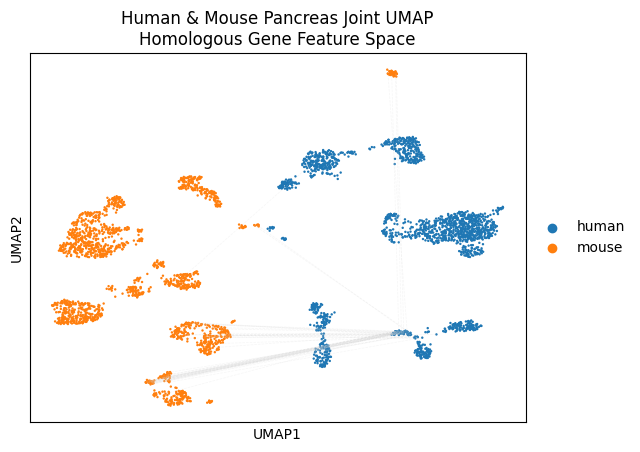

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


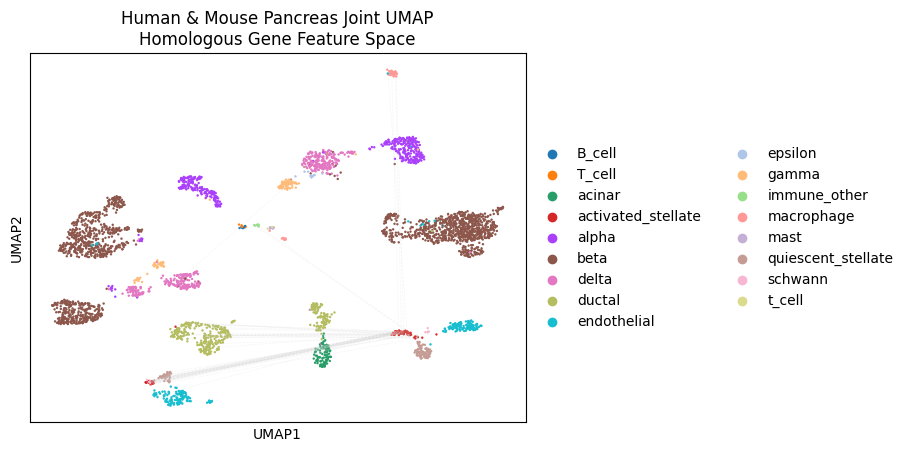

In [21]:
cell_type_label = "activated_stellate"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


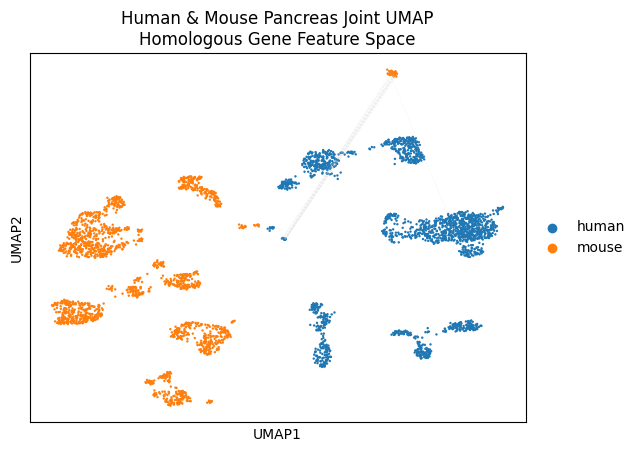

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


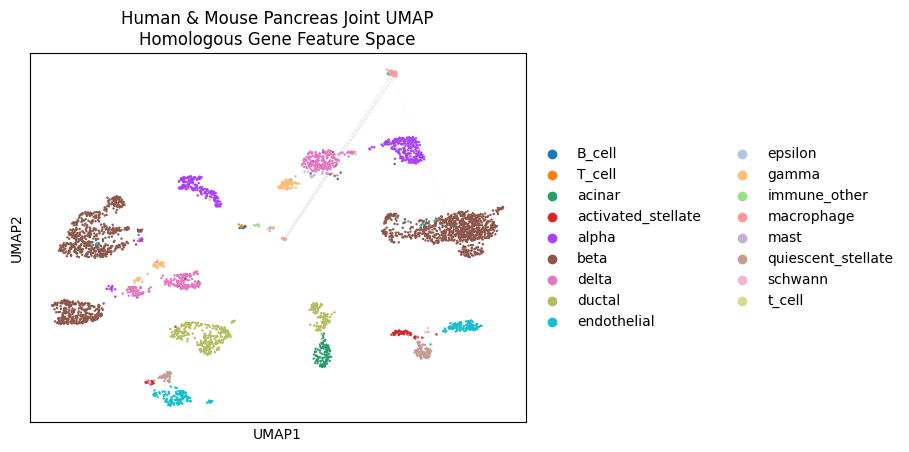

In [22]:
cell_type_label = "macrophage"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


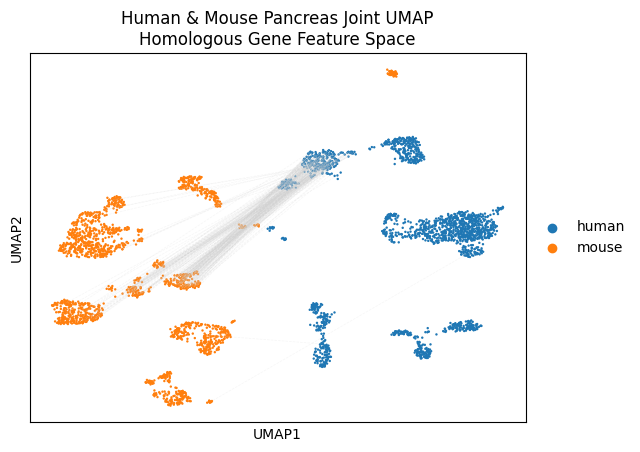

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


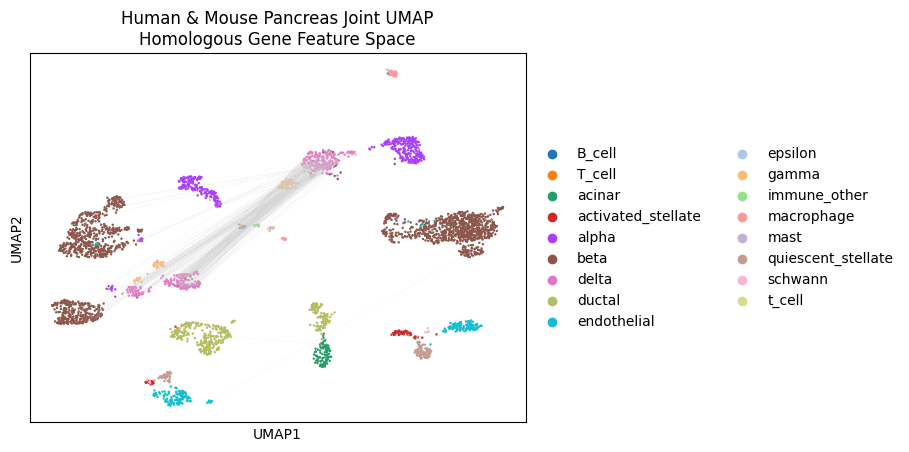

In [23]:
cell_type_label = "delta"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

In [24]:
list(set(human_mouse_adata.obs["cell_types"]))

['immune_other',
 'acinar',
 'ductal',
 'delta',
 'quiescent_stellate',
 'T_cell',
 'beta',
 't_cell',
 'alpha',
 'macrophage',
 'schwann',
 'epsilon',
 'activated_stellate',
 'mast',
 'gamma',
 'B_cell',
 'endothelial']

In [25]:
plot_cell_types = [
    't_cell',
    'B_cell',
    'acinar',
    'epsilon',
    'T_cell',
    'mast',
    'schwann',
    'immune_other',
    'quiescent_stellate'
]

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


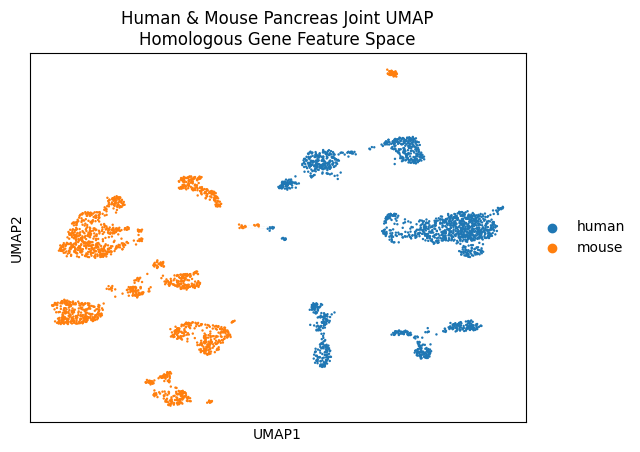

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


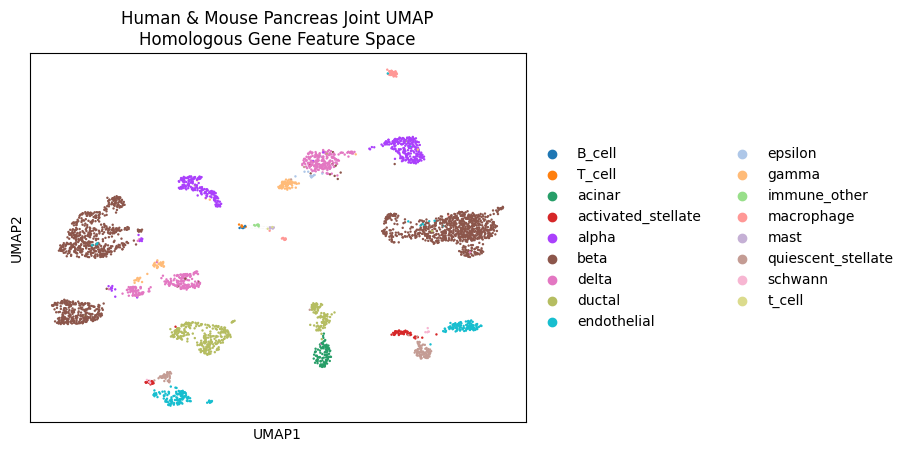

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


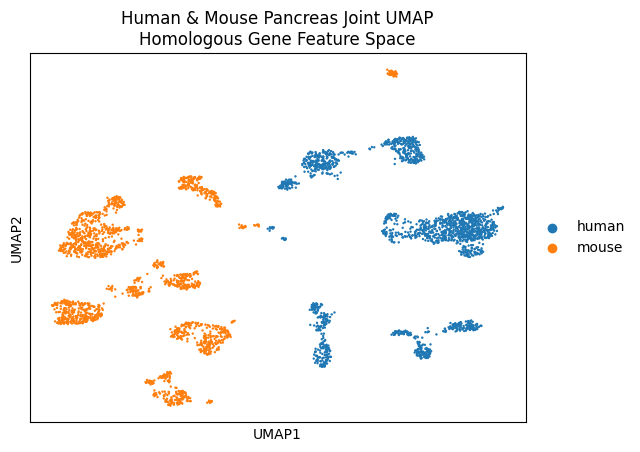

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


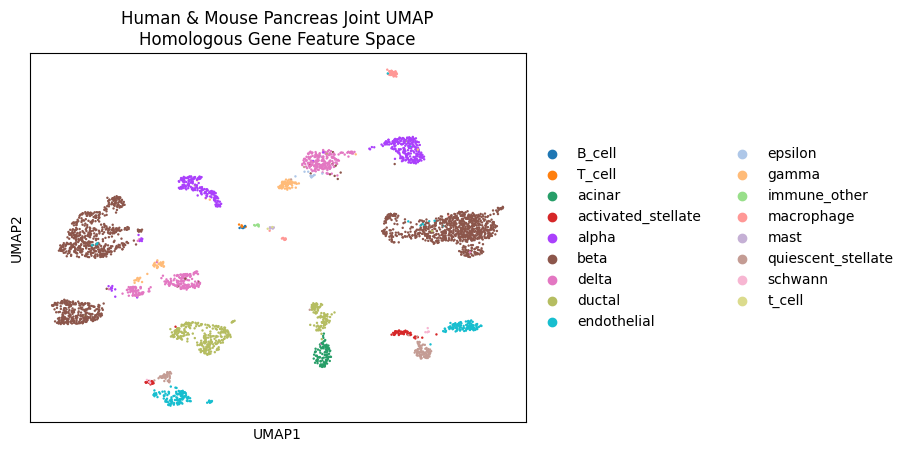

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


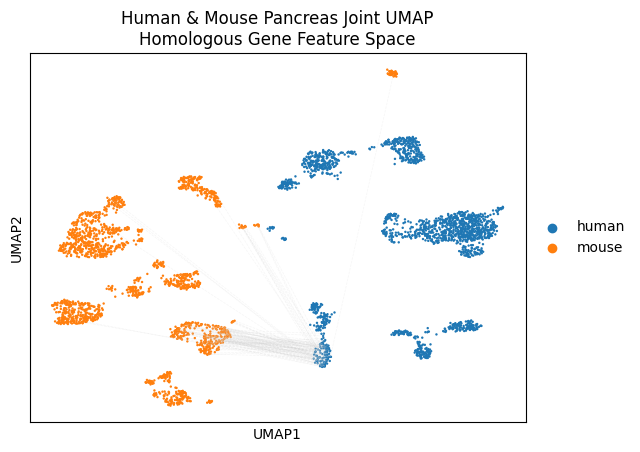

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


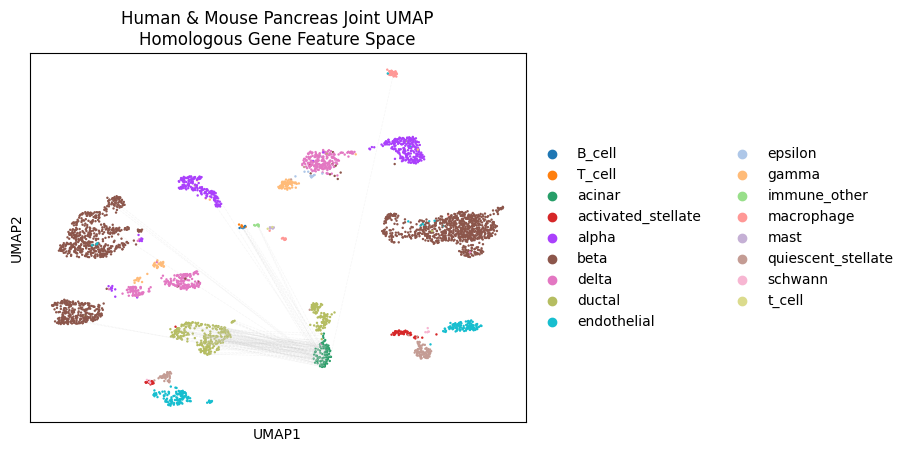

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


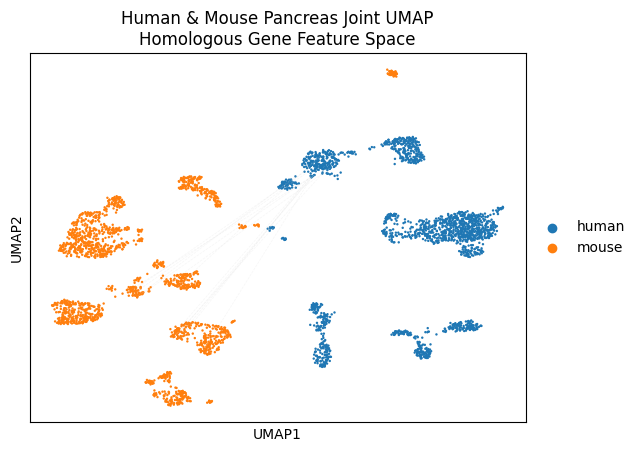

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


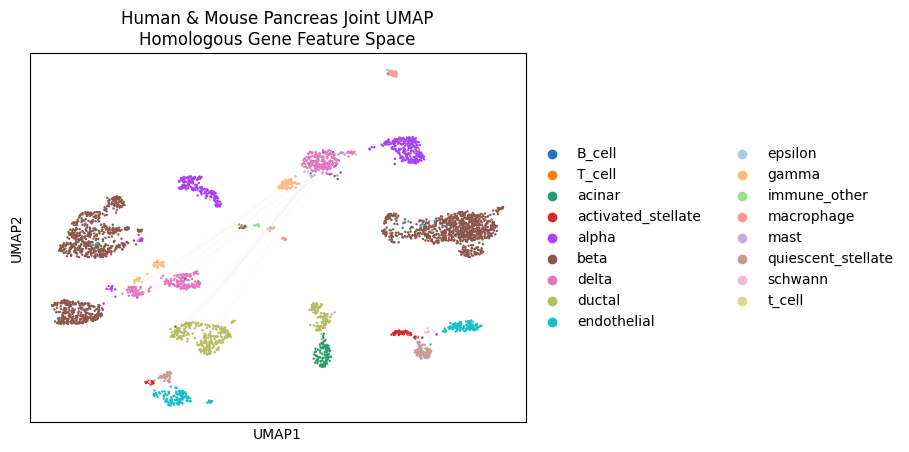

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


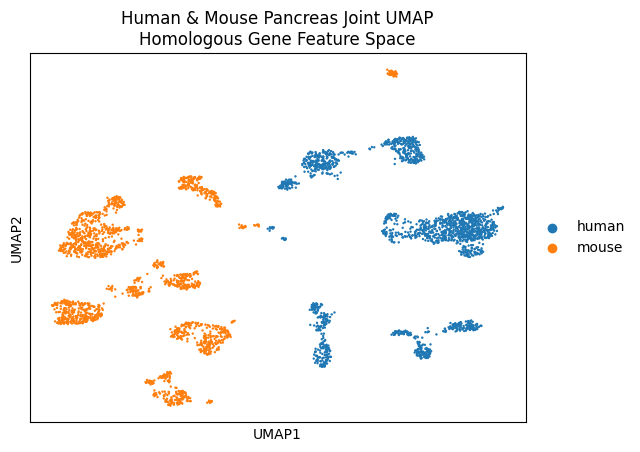

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


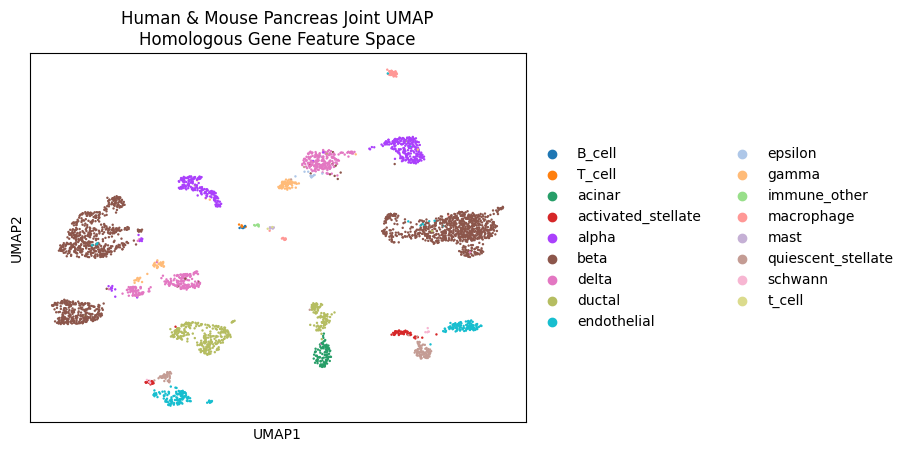

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


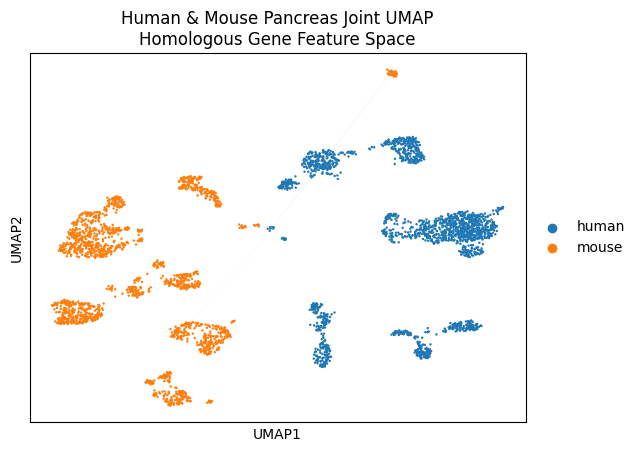

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


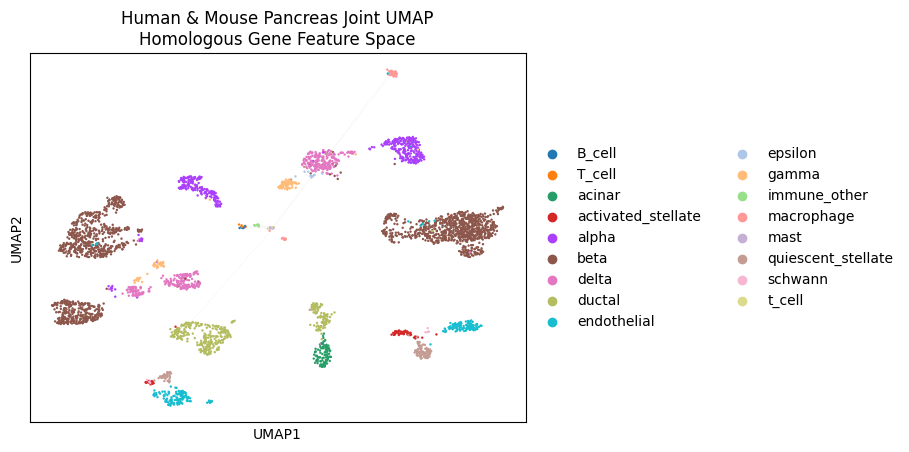

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


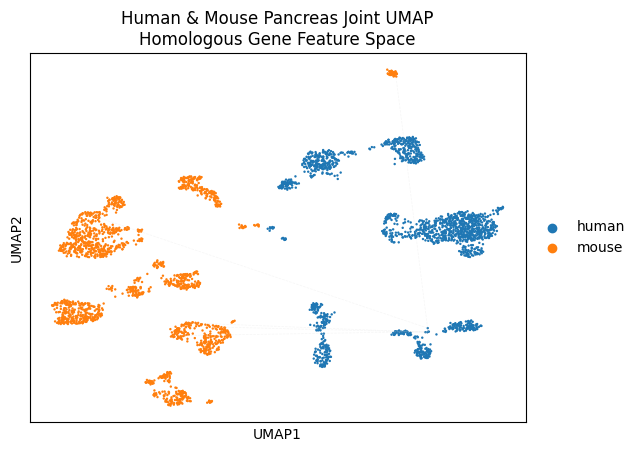

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


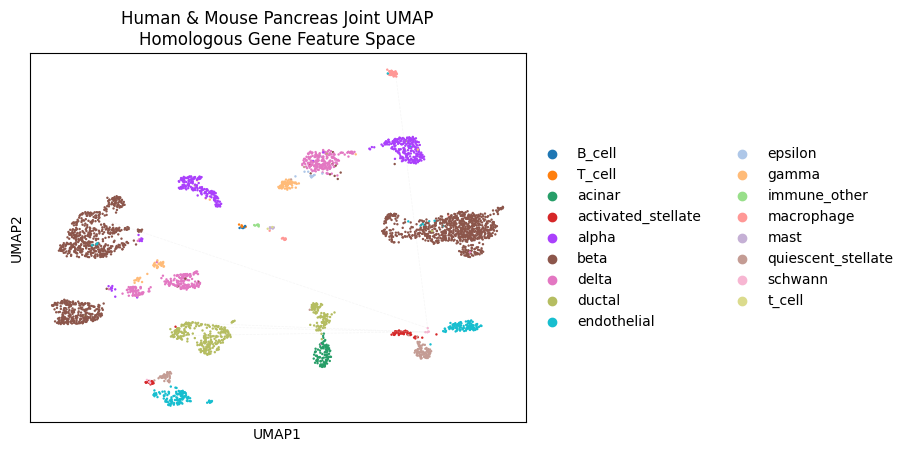

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


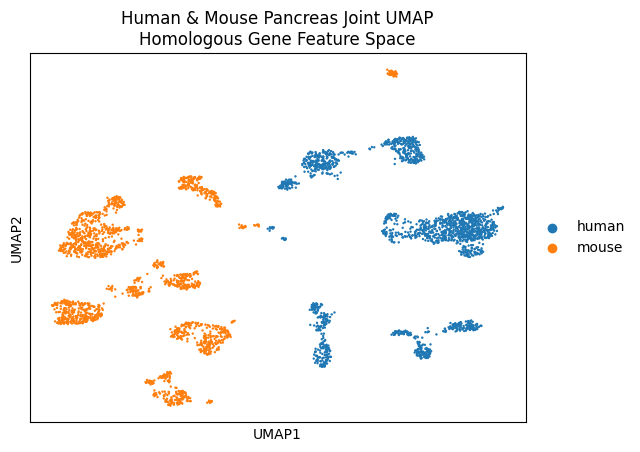

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


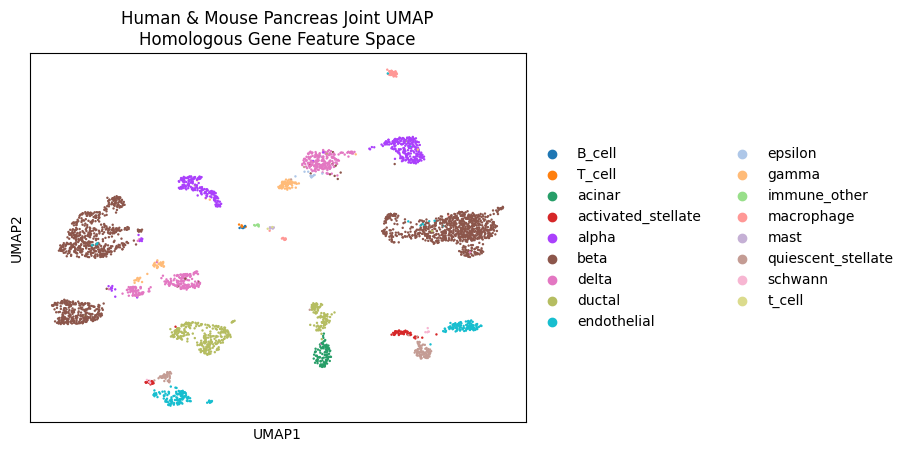

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


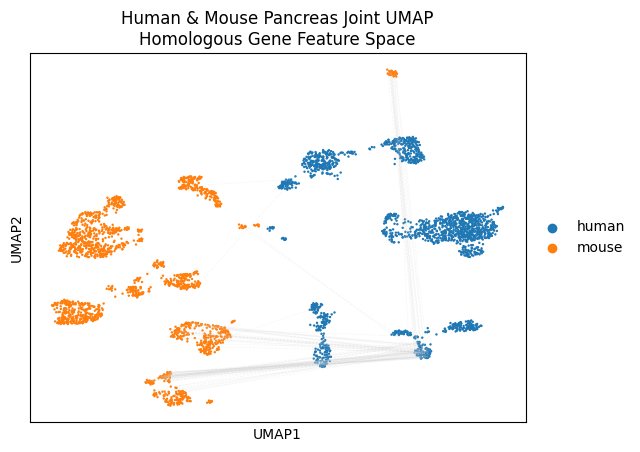

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


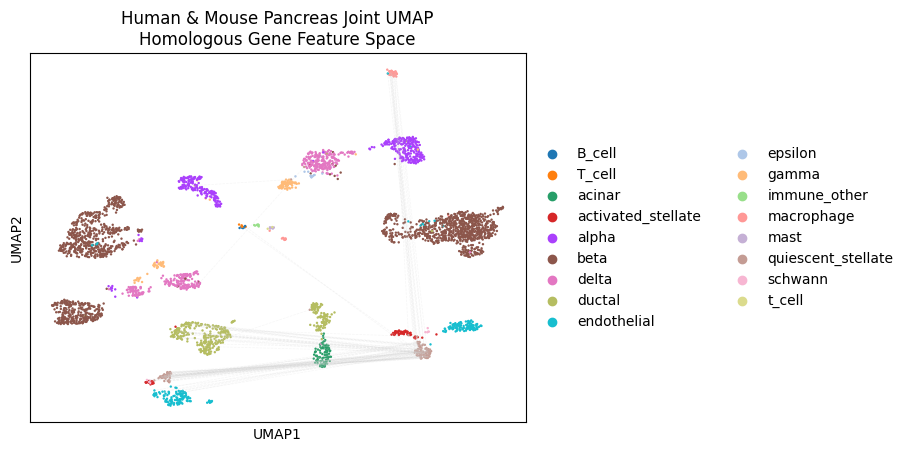

In [26]:
for cell_type_label in plot_cell_types:
    plot_joint_umap_with_pairs(
        human_mouse_joint_adata=human_mouse_adata, 
        num_human_cells=human_restricted.shape[0], 
        paired_indices=paired_indices,
        color_label="species_label",  # species_label, cell_types
        save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
        cell_type=cell_type_label,
        adata_human=human_restricted,
        adata_mouse=mouse_restricted,
        filter_by_human=human_to_mouse
    )
    plot_joint_umap_with_pairs(
        human_mouse_joint_adata=human_mouse_adata, 
        num_human_cells=human_restricted.shape[0], 
        paired_indices=paired_indices,
        color_label="cell_types",  # species_label, cell_types
        save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
        cell_type=cell_type_label,
        adata_human=human_restricted,
        adata_mouse=mouse_restricted,
        filter_by_human=human_to_mouse
    )